In [1]:
import shioaji as sj

api = sj.Shioaji(simulation=True)
accounts = api.login(
    api_key="3WmNiNGCQMuPGsRMdpgML3MWYkqM1gExzPUGKKcjhufd",     # 請修改此處
    secret_key="EnKAve1Ldd8wuerMRcwKUUrB4DRmLyoxCSyoApmbzrTM"   
)

2023-04-23 22:48:51.603 | WARNING  | importlib._bootstrap:_call_with_frames_removed:228 - Optional: pip install shioaji[speed] for better performance.


Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


In [6]:
import datetime
import pandas as pd
import os
import numpy as np

days = 376

kbars = api.kbars(
    contract=api.Contracts.Futures.TXF.TXFR1, 
    start=(datetime.datetime.now() - datetime.timedelta(days=days)).strftime("%Y-%m-%d"), 
    end=datetime.datetime.now().strftime("%Y-%m-%d"),
)

df = pd.DataFrame({**kbars})
df.ts = pd.to_datetime(df.ts)
df = df.set_index('ts')
df.index.name = None
df_1min = df

df_1min = df_1min[['Open', 'High', 'Low', 'Close', 'Volume']]
df_1min.to_csv('TXF_1min.csv')

使用5分K，日盤資料

In [7]:
import pandas as pd


df = pd.read_csv(f"TXF_1min.csv", index_col=0)

df.index = pd.to_datetime(df.index)
df= df.between_time('08:44:00', '13:45:01')
df_resample = df.resample('5T', label='right', closed='right').agg(
    {'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
     'Volume':'sum'
    })
df_resample.dropna(axis=0, inplace=True)
df = df_resample
print(df.head())
print(df.tail())

                        Open     High      Low    Close  Volume
2022-04-12 08:50:00  16960.0  16976.0  16950.0  16966.0    3664
2022-04-12 08:55:00  16967.0  16972.0  16938.0  16946.0    2378
2022-04-12 09:00:00  16947.0  16966.0  16936.0  16944.0    2192
2022-04-12 09:05:00  16944.0  16953.0  16906.0  16930.0    4817
2022-04-12 09:10:00  16928.0  16995.0  16919.0  16995.0    5237
                        Open     High      Low    Close  Volume
2023-04-21 13:25:00  15617.0  15628.0  15615.0  15619.0    1627
2023-04-21 13:30:00  15619.0  15621.0  15602.0  15614.0    1968
2023-04-21 13:35:00  15613.0  15618.0  15604.0  15618.0    1737
2023-04-21 13:40:00  15616.0  15622.0  15614.0  15620.0     946
2023-04-21 13:45:00  15620.0  15621.0  15613.0  15615.0    1855


策略部分

# 策略

**使用威廉指標當作技術指標**

多單策略：

進場：
* WR向上超越超買區(-30)
* 開盤15分鐘後進場

出場：
* 百分比停損 0.1%
* 跌破3根低點停利停損 
* WR跌出超買區
* 13.30平倉


空單策略：

進場：
* WR向下超越超賣區(-75)
* 開盤15分鐘後進場

出場：
* 百分比停損 0.1%
* 超出3根高點停利停損 
* WR向上超出超賣區
* 13.30平倉

In [24]:
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

from datetime import time

#使用威廉指標當作技術指標
class WL(Strategy): 

    WL = 65
    OB = -15
    stop_pct = 5 #表示0.5%
    OS = -80
    L = 2
    n1 = 7
    
    fast_period = 12
    slow_period = 26
    signal_period = 9
    proportion = 0.9

    def init(self):
        self.wl = self.I(ta.WILLR, self.data.High, self.data.Low, self.data.Close, self.WL)
        self.macd = self.I(ta.MACD, self.data.Close, fastperiod=self.fast_period, slowperiod=self.slow_period, signalperiod=self.signal_period)
        self.min = self.I(ta.MIN, self.data.Low, self.L)
        self.max = self.I(ta.MAX, self.data.High, self.L)
        self.sma = self.I(ta.SMA, self.data.Close, self.n1)
        self.proportion = 0.9

    def next(self):
                
#         curr_macd = self.macd[2][-1]
#         prev_macd = self.macd[2][-2]

#         macd_now = self.macd[0][-1]
#         signal_now = self.macd[1][-1]

#         signal = 0
#         # MACD crosses the zero line from below - buy signal
#         if prev_macd < 0 and curr_macd > 0:
#             signal = 1
        
#         # MACD crosses the zero line from above - sell signal
#         elif prev_macd > 0 and curr_macd < 0:
#             signal = -1
        
        
        
        if (self.data.index[-1].time() < time(13, 30)) and (self.data.index[-1].time() > time(9, 0)) and (not self.position.is_long): # 多單
            if (self.wl[-2] < self.OB) and (self.wl > self.OB): # 多單進場
                self.buy(size=200)
        if self.position.is_long: # 多單出場
            if self.wl[-2] > self.OB and self.wl < self.OB: #WR跌出超買區
                self.position.close()
#             elif self.data.Close[-1] <= self.min: #跌破3根低點停利停損
#                 self.position.close()
            elif self.position.pl_pct < -(self.stop_pct * 0.001): #百分比停損
                self.position.close()
                
                
        if (self.data.index[-1].time() > time(13, 30)) and (self.data.index[-1].time() > time(9, 0)) and (not self.position.is_short): # 空單
            if (self.wl[-2] < self.OS) and (self.wl > self.OS): # 空單進場
                self.sell(size=200)
        if self.position.is_short: # 空單出場
            if self.wl[-2] > self.OS and self.wl < self.OS: #WR向上超出超賣區
                self.position.close()
#             elif self.data.Close[-1] >= self.max:
#                 self.position.close()
            elif self.position.pl_pct < -(self.stop_pct * 0.001): #百分比停損
                self.position.close()
        
        if self.data.index[-1].time() >= time(13, 30) and (self.position.is_long or self.position.is_short): #平倉
                self.position.close()
    

回測部分(包含樣本內外)

In [30]:
from backtesting import Backtest
df_all = df[df.index >= '2022-04-14']
df_out_sample = df_all[df_all.index >= '2022-12-17']
bt = Backtest(df_out_sample, WL, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.run()
print(stats)
# bt.plot(resample=False)

Start                     2022-12-19 08:50:00
End                       2023-04-21 13:45:00
Duration                    123 days 04:55:00
Exposure Time [%]                   17.741228
Equity Final [$]                   600906.724
Equity Peak [$]                   607116.3334
Return [%]                          20.181345
Buy & Hold Return [%]                8.641202
Return (Ann.) [%]                    83.95978
Volatility (Ann.) [%]               25.821827
Sharpe Ratio                         3.251504
Sortino Ratio                       15.552232
Calmar Ratio                        29.764718
Max. Drawdown [%]                   -2.820782
Avg. Drawdown [%]                   -0.968612
Max. Drawdown Duration       22 days 00:45:00
Avg. Drawdown Duration        3 days 12:44:00
# Trades                                   84
Win Rate [%]                        41.666667
Best Trade [%]                       0.777723
Worst Trade [%]                     -0.235343
Avg. Trade [%]                    

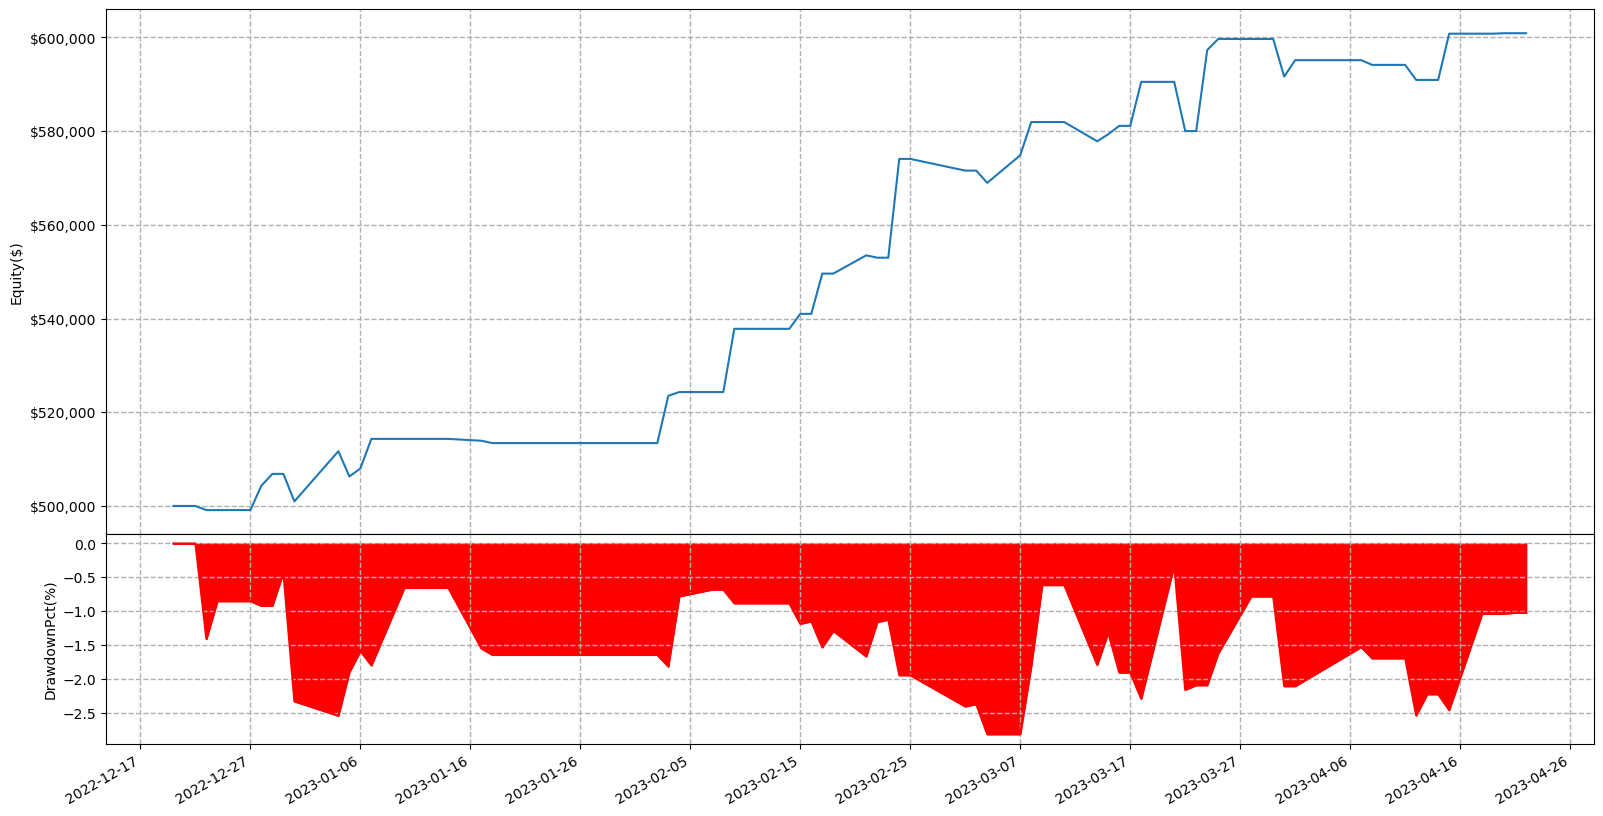

SDK NOTICE Sun Apr 23 23:10:00.388 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57257'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun Apr 23 23:10:34.069 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57335'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Sun Apr 23 23:26:43.706 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57337'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting


SDK NOTICE Sun Apr 23 23:26:46.747 2023 solClient.c:12123                    (30e34c000) Connect attempt for host '203.66.91.161:80' for session '(c0,s1)_sinopac(client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57338')' timed out
SDK NOTICE Sun Apr 23 23:26:52.847 2023 solClient.c:12123                    (30e34c000) Connect attempt for host '203.66.91.161:80' for session '(c0,s1)_sinopac(client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57341')' timed out
SDK NOTICE Sun Apr 23 23:26:58.966 2023 solClient.c:12123                    (30e34c000) Connect attempt for host '203.66.91.161:80' for session '(c0,s1)_sinopac(client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VP

Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 4 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 00:20:02.171 2023 solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)
SDK NOTICE Mon Apr 24 00:20:02.171 2023 solClientSmf.c:7171                  (30e34c000) Read failed from transport 'compression' of session '(c0,s1)_sinopac' due to 'solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)', client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57351'


Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 00:52:40.318 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57356'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 01:25:48.087 2023 solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)
SDK NOTICE Mon Apr 24 01:25:48.088 2023 solClientSmf.c:7171                  (30e34c000) Read failed from transport 'compression' of session '(c0,s1)_sinopac' due to 'solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)', client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57375'


Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 01:59:54.792 2023 solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)
SDK NOTICE Mon Apr 24 01:59:54.792 2023 solClientSmf.c:7171                  (30e34c000) Read failed from transport 'compression' of session '(c0,s1)_sinopac' due to 'solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)', client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57386'


Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 02:33:20.207 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57391'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 03:07:10.992 2023 solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)
SDK NOTICE Mon Apr 24 03:07:10.992 2023 solClientSmf.c:7171                  (30e34c000) Read failed from transport 'compression' of session '(c0,s1)_sinopac' due to 'solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)', client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57410'


Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 03:41:27.144 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57414'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 04:14:41.916 2023 solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)
SDK NOTICE Mon Apr 24 04:14:41.917 2023 solClientSmf.c:7171                  (30e34c000) Read failed from transport 'compression' of session '(c0,s1)_sinopac' due to 'solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)', client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57432'


Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 04:46:52.044 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57445'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 05:17:35.843 2023 solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)
SDK NOTICE Mon Apr 24 05:17:35.843 2023 solClientSmf.c:7171                  (30e34c000) Read failed from transport 'compression' of session '(c0,s1)_sinopac' due to 'solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)', client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57468'


Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 05:50:03.533 2023 solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)
SDK NOTICE Mon Apr 24 05:50:03.533 2023 solClientSmf.c:7171                  (30e34c000) Read failed from transport 'compression' of session '(c0,s1)_sinopac' due to 'solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)', client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57483'


Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 06:22:48.200 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57498'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 06:55:23.240 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57515'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 07:29:19.992 2023 solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)
SDK NOTICE Mon Apr 24 07:29:19.992 2023 solClientSmf.c:7171                  (30e34c000) Read failed from transport 'compression' of session '(c0,s1)_sinopac' due to 'solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)', client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57524'


Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 08:02:06.202 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57532'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 08:36:05.964 2023 solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)
SDK NOTICE Mon Apr 24 08:36:05.964 2023 solClientSmf.c:7171                  (30e34c000) Read failed from transport 'compression' of session '(c0,s1)_sinopac' due to 'solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60)', client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57549'


Response Code: 0 | Event Code: 12 | Info: solClientOS.c:5777                   (30e34c000) TCP: Could not read from socket 84, error = Operation timed out (60) | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 08:52:46.493 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57554'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 09:00:58.631 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57571'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting
Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 1 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 09:25:48.737 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57589'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting


SDK NOTICE Mon Apr 24 09:25:51.802 2023 solClient.c:12123                    (30e34c000) Connect attempt for host '203.66.91.161:80' for session '(c0,s1)_sinopac(client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57623')' timed out


Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 2 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 10:29:09.781 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:57632'


Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting


SDK NOTICE Mon Apr 24 10:29:12.829 2023 solClient.c:12123                    (30e34c000) Connect attempt for host '203.66.91.161:80' for session '(c0,s1)_sinopac(client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:58021')' timed out
SDK NOTICE Mon Apr 24 10:29:18.916 2023 solClient.c:12123                    (30e34c000) Connect attempt for host '203.66.91.161:80' for session '(c0,s1)_sinopac(client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:58022')' timed out
SDK NOTICE Mon Apr 24 10:29:24.996 2023 solClient.c:12123                    (30e34c000) Connect attempt for host '203.66.91.161:80' for session '(c0,s1)_sinopac(client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VP

Response Code: 0 | Event Code: 13 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total reconnection attempt 4 of 10) | Event: Session reconnected


SDK NOTICE Mon Apr 24 11:42:39.851 2023 solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 192.168.0.119:58024'
SDK NOTICE Mon Apr 24 11:42:39.852 2023 solClientOS.c:4470                   (30e34c000) TCP connection failure for fd 84, error = Network is unreachable (51)
SDK NOTICE Mon Apr 24 11:42:39.852 2023 solClient.c:6147                     (30e34c000) Session '(c0,s1)_sinopac', could not open transport for tcp_TxRx
SDK NOTICE Mon Apr 24 11:42:39.852 2023 solClient.c:11240                    (30e34c000) Session '(c0,s1)_sinopac' error attempting transport connection, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 

Response Code: 0 | Event Code: 12 | Info: solClient.c:12194                    (30e34c000) Session '(c0,s1)_sinopac' keep-alive on tcp_TxRx detected session down, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203 | Event: Session reconnecting


SDK NOTICE Mon Apr 24 11:58:13.575 2023 solClientOS.c:4470                   (30e34c000) TCP connection failure for fd 84, error = Network is unreachable (51)
SDK NOTICE Mon Apr 24 11:58:13.575 2023 solClient.c:6147                     (30e34c000) Session '(c0,s1)_sinopac', could not open transport for tcp_TxRx
SDK NOTICE Mon Apr 24 11:58:13.575 2023 solClient.c:11240                    (30e34c000) Session '(c0,s1)_sinopac' error attempting transport connection, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 0.0.0.0:58375'
SDK NOTICE Mon Apr 24 11:58:13.575 2023 solClient.c:11395                    (30e34c000) Protocol or communication error when attempting to login for session '(c0,s1)_sinopac'; are session HOST and PORT correct? client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66

SDK NOTICE Mon Apr 24 12:32:44.425 2023 solClientOS.c:4470                   (30e34c000) TCP connection failure for fd 84, error = Network is unreachable (51)
SDK NOTICE Mon Apr 24 12:32:44.425 2023 solClient.c:6147                     (30e34c000) Session '(c0,s1)_sinopac', could not open transport for tcp_TxRx
SDK NOTICE Mon Apr 24 12:32:44.425 2023 solClient.c:11240                    (30e34c000) Session '(c0,s1)_sinopac' error attempting transport connection, client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66.91.161:80' IP 203.66.91.161:80', connection 'tcp_TxRx' local address 'IP 0.0.0.0:58929'
SDK NOTICE Mon Apr 24 12:32:44.425 2023 solClient.c:11395                    (30e34c000) Protocol or communication error when attempting to login for session '(c0,s1)_sinopac'; are session HOST and PORT correct? client name 'PYAPI/A131461990/0423/144854/729345/118.166.219.73', VPN name 'sinopac', peer address 'hostname '203.66

Session Down.
Response Code: 0 | Event Code: 1 | Info: solClientOS.c:4470                   (30e34c000) TCP connection failure for fd 84, error = Network is unreachable (51) | Event: Session down


In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()

In [96]:
# df_in_sample = df[df.index >= '2022-12-17']
# bt = Backtest(df, WL, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
# stats = bt.optimize(
#                     OB=range(-5, -35, -5),
#                     OS=range(-95, -65, 5),
# #                     stop_pct=range(1, 10, 2),
# #                     L=range(2,10,1),
#                     maximize='Equity Final [$]',
#                     ) # 快線週期<慢線週期
# print(stats.to_string())

/Users/yun_yang/opt/anaconda3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/9 [00:00<?, ?it/s]

Start                                                   2023-02-06 08:50:00
End                                                     2023-04-07 12:05:00
Duration                                                   60 days 03:15:00
Exposure Time [%]                                                 14.663866
Equity Final [$]                                                572532.0252
Equity Peak [$]                                                  581197.344
Return [%]                                                        14.506405
Buy & Hold Return [%]                                              2.399897
Return (Ann.) [%]                                                134.761899
Volatility (Ann.) [%]                                             42.407714
Sharpe Ratio                                                       3.177769
Sortino Ratio                                                     21.626122
Calmar Ratio                                                      54.952154
Max. Drawdow

In [27]:
df_out_sample = df_all[df_all.index >= '2022-12-17']
bt = Backtest(df, WL, cash=500_000, commission=0.000033, hedging=False, margin=0.05)
stats = bt.run()
print(stats.to_string())
bt.plot(resample=False)

Start                                                   2022-04-12 08:50:00
End                                                     2023-04-21 13:45:00
Duration                                                  374 days 04:55:00
Exposure Time [%]                                                 17.144754
Equity Final [$]                                                587307.1536
Equity Peak [$]                                                  593516.763
Return [%]                                                        17.461431
Buy & Hold Return [%]                                             -7.962985
Return (Ann.) [%]                                                 17.536771
Volatility (Ann.) [%]                                             29.379828
Sharpe Ratio                                                       0.596898
Sortino Ratio                                                       0.93967
Calmar Ratio                                                       0.602186
Max. Drawdow

Row(id='1643', ...)

In [ ]:
from backtesting.lib import crossover
df_5min = []
while(len(df_5min) < bars):
    kbars = api.kbars(
        contract=api.Contracts.Futures.TXF.TXFR1,
        start=(datetime.date.today() -  
               datetime.timedelta(days=days)).strftime("%Y-%m-%d"),
        end=datetime.date.today().strftime("%Y-%m-%d"),
    )
    df = pd.DataFrame({**kbars})
    df.ts = pd.to_datetime(df.ts)
    df = df.set_index('ts')
    df.index.name = None
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df = df.between_time('08:44:00', '13:45:01')
    df_5min = df.resample('5T', label='right', closed='right').agg(
        {'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
         })
    df_5min.dropna(axis=0, inplace=True)
    days += 1

ts = datetime.datetime.now()

while datetime.datetime.now().time() < datetime.time(12, 30):

    # this place can add stop or limit order
    self_list_positions = order.list_positions(msg_queue['bidask'][-1])
    self_position = 'None' if len(
        self_list_positions) == 0 else self_list_positions['direction']
    if self_position == 'Buy':
        if msg_queue['bidask'][-1]['ask_price'][0] < (self_list_positions['price'] * 0.999):
            order.place_order(msg_queue['bidask'][-1], 'Sell', 'Cover')

    # local time > next kbars time
    if(datetime.datetime.now() >= ts):

        kbars = api.kbars(
            contract=api.Contracts.Futures.TXF.TXFR1,
            start=datetime.date.today().strftime("%Y-%m-%d"),
            end=datetime.date.today().strftime("%Y-%m-%d"),
        )
        df = pd.DataFrame({**kbars})
        df.ts = pd.to_datetime(df.ts)
        df = df.set_index('ts')
        df.index.name = None
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
        df = df.between_time('08:44:00', '13:45:01')
        df = df.resample('5T', label='right', closed='right').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'})
        df.dropna(axis=0, inplace=True)
        df_5min.update(df)
        to_be_added = df.loc[df.index.difference(df_5min.index)]
        df_5min = pd.concat([df_5min, to_be_added])
        ts = df_5min.iloc[-1].name.to_pydatetime()

        # next kbar time update and local time < next kbar time
        if (datetime.datetime.now().minute != ts.minute):

            df_5min = df_5min[:-1]
            time_period = 18
            adx_bound = 25
            WL = 65
            OB = -30
            L = 3
            
            n1 = 27
            n2 = 33
            
            self_wl = ta.WILLR(
                df_5min['High'], df_5min['Low'], df_5min['Close'], WL)
            self_min = ta.MIN(df_5min['Low'], L)
            self_sma = ta.SMA(df_5min['Close'], n1)
            
            self_pdi = ta.PLUS_DI(df_5min['High'], df_5min['Low'], df_5min['Close'], time_period)
            self_mdi = ta.MINUS_DI(df_5min['High'], df_5min['Low'], df_5min['Close'], time_period)
            self_adx = ta.ADX(df_5min['High'], df_5min['Low'], df_5min['Close'], time_period)
            
            self_sma1 = ta.SMA(df_5min['Close'], n1) # sma 快線
            self_sma2 = ta.SMA(df_5min['Close'], n2) # sma 慢線
            
            curr_pdi = self_pdi[-1]
            curr_mdi = self_mdi[-1]
            curr_adx = self_adx[-1]
            prev_pdi = self_pdi[-2]
            prev_mdi = self_mdi[-2]
            signal = 0
            if curr_adx > adx_bound:
                if curr_pdi > curr_mdi and prev_pdi < prev_mdi:
                    signal = 1
                if curr_pdi < curr_mdi and prev_pdi > prev_mdi:
                    signal = -1
            
            condition1 = datetime.datetime.now().time() < datetime.time(12, 25)
            condition2 = datetime.datetime.now().time() > datetime.time(9, 0)
#             condition3 = (self_wl[-2] < OB) and (self_wl[-1] > OB)
            condition3 = signal==1 #Buy
#             condition4 = (self_wl[-2] > OB) and (self_wl[-1] < OB)
            condition4 = signal==-1 #Sell
            condition5 = crossover(self_sma2 , self_sma1) #Sell
            condition6 = datetime.datetime.now().time() >= datetime.time(12, 25) #Sell
            condition7 = crossover(self_sma1 , self_sma2) #Buy
            condition8 = crossover(df_5min['Close'][-1] , self_sma1) #Buy
            
            self_list_positions = order.list_positions(msg_queue['bidask'][-1])

            self_position = 'None' if len(
                self_list_positions) == 0 else self_list_positions['direction']
                
                
            
            if self_position!="None":
                self_entry_price = self_list_positions["price"]
                self_pnl = self_list_positions['pnl']
                self_pct = self_pnl / self_entry_price
                
                print(self_pct)
            if self_position == 'None':
                if condition1 and condition2:
                    if condition3 or condition7 or condition8:
                        order.place_order(
                            msg_queue['bidask'][-1], 'Buy', 'New')
                    elif condition4 or condition5:
                        order.place_order(
                            msg_queue['bidask'][-1], 'Sell', 'New')
            elif self_position == 'Buy':
                if condition4:
                    order.place_order(msg_queue['bidask'][-1], 'Sell', 'Cover')
                    order.place_order(msg_queue['bidask'][-1], 'Sell', 'New')
                elif condition5:
                    order.place_order(msg_queue['bidask'][-1], 'Sell', 'Cover')
                    order.place_order(msg_queue['bidask'][-1], 'Sell', 'New')
                elif condition6:
                    order.place_order(msg_queue['bidask'][-1], 'Sell', 'Cover')
                    break
            elif self_position =="Sell":
                if condition3:
                    order.place_order(msg_queue['bidask'][-1], 'Buy', 'Cover')
                    order.place_order(msg_queue['bidask'][-1], 'Buy', 'New')
                elif condition7:
                    order.place_order(msg_queue['bidask'][-1], 'Buy', 'Cover')
                    order.place_order(msg_queue['bidask'][-1], 'Buy', 'New')
                elif condition8:
                    order.place_order(msg_queue['bidask'][-1], 'Buy', 'Cover')
                    order.place_order(msg_queue['bidask'][-1], 'Buy', 'New')
                elif condition6:
                    order.place_order(msg_queue['bidask'][-1], 'Buy', 'Cover')
                    break
            if self_position == "Buy" and self_pct < -0.004:
                order.place_order(msg_queue['bidask'][-1], 'Sell', 'Cover')
            elif self_position == "Sell" and self_pct < -0.004:
                order.place_order(msg_queue['bidask'][-1], 'Buy', 'Cover')